In [57]:
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
#import helper_functions as helper

In [58]:
import os
#give path to the IPN Analysis
path = '/home/benshalom/MEA_Analysis/IPNAnalysis'
os.chdir(path)

In [59]:
#Reading the file, BP filtering
local_path= '/home/benshalom/Data/MEASlices_02242025_PVSandCA/MEASlices_02242025_PVSandCA/250224/M07305/Network/000005/data.raw.h5' #network data from chip 16848
recording1 = se.read_maxwell(local_path,stream_id = 'well002')
freq_min = 300
freq_max = 4500


#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=freq_min, freq_max=freq_max)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=300*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")


Sampling frequency: 10000.0
Number of channels: 1020
Number of segments: 1
total_recording: 300.0 s
chunk duration: 300.0 s


In [60]:
electrodes = []
channel_location_dict = {}
channel_ids = recording_chunk.get_channel_ids()
locations = recording_chunk.get_channel_locations()
for channel,locations in zip(channel_ids, locations):
    electrodes.append(220* int(locations[1]/17.5)+int(locations[0]/17.5))

    # Convert the coordinates to the desired format
    # Assuming the coordinates are in micrometers and you want to convert them to millimeters
    # Adjust the conversion factor as needed
    # For example, if the coordinates are in micrometers, divide by 1000 to convert to millimeters
    # Here we assume a 17.5 mm grid for the electrodes

print(electrodes)
print(len(electrodes))

[12145, 13199, 13431, 15397, 14317, 14939, 13423, 13633, 10805, 15803, 12571, 12317, 11695, 14041, 13025, 13597, 12553, 13537, 9947, 12733, 13049, 12753, 13015, 18431, 14351, 9235, 14783, 11847, 13441, 14919, 14311, 16277, 12117, 12739, 14361, 14019, 10865, 10059, 13477, 16699, 11683, 13625, 12579, 17559, 9497, 13621, 16073, 11375, 11237, 13133, 15195, 17149, 12541, 11867, 13925, 18009, 12561, 11863, 15191, 9637, 9943, 14015, 13445, 14447, 15209, 13593, 12181, 14485, 15623, 12745, 13459, 16671, 9075, 11851, 14809, 18025, 10821, 15755, 15213, 18029, 10341, 7475, 16079, 18877, 14743, 11401, 14339, 14049, 14333, 14055, 14325, 13629, 14329, 11857, 12567, 17133, 9473, 11439, 12591, 16663, 14307, 13605, 16089, 17597, 11715, 14875, 16943, 17153, 7749, 9187, 13435, 18013, 9037, 14935, 16539, 14929, 12597, 9661, 16067, 19347, 9917, 10539, 17823, 14945, 12105, 14915, 13471, 16687, 8587, 7879, 17389, 24631, 5517, 8769, 22235, 21083, 2019, 8325, 22225, 21091, 8607, 7003, 21383, 14899, 9467, 10945,

In [61]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
%matplotlib widget

# Visualize the traces interactively
print("Visualizing traces interactively...")
sw.plot_traces(recording_chunk, mode='line', show_channel_ids=True, backend='ipywidgets')  # Updated function name

# Create a text box for user input
electrode_input = widgets.Text(
    description="Electrode:",
    placeholder="Enter electrode number",
)

# Create an output widget to display the result
output = widgets.Output()

# Define a function to handle the input and display the corresponding channel indices
def find_channel_indices(change):
    with output:
        output.clear_output()  # Clear previous output
        try:
            # Get the input value and split it into a list of electrode numbers
            electrode_numbers = [int(e.strip()) for e in change["new"].split(",")]
            channel_indices = []
            for electrode_number in electrode_numbers:
                if electrode_number in electrodes:
                    channel_index = electrodes.index(electrode_number)  # Find the index
                    channel_indices.append(channel_index)
                else:
                    print(f"Electrode {electrode_number} not found.")
            if channel_indices:
                print(f"Electrode numbers {electrode_numbers} correspond to Channel Indices {channel_indices}")
        except ValueError:
            print("Please enter valid integers separated by commas.")

# Attach the function to the text box
electrode_input.observe(find_channel_indices, names="value")

# Display the widgets
display(widgets.VBox([electrode_input, output]))



Visualizing traces interactively...


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [62]:
locations = recording_chunk.get_channel_locations()
print(locations.shape)
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids.shape)

(1020, 2)
(1020,)


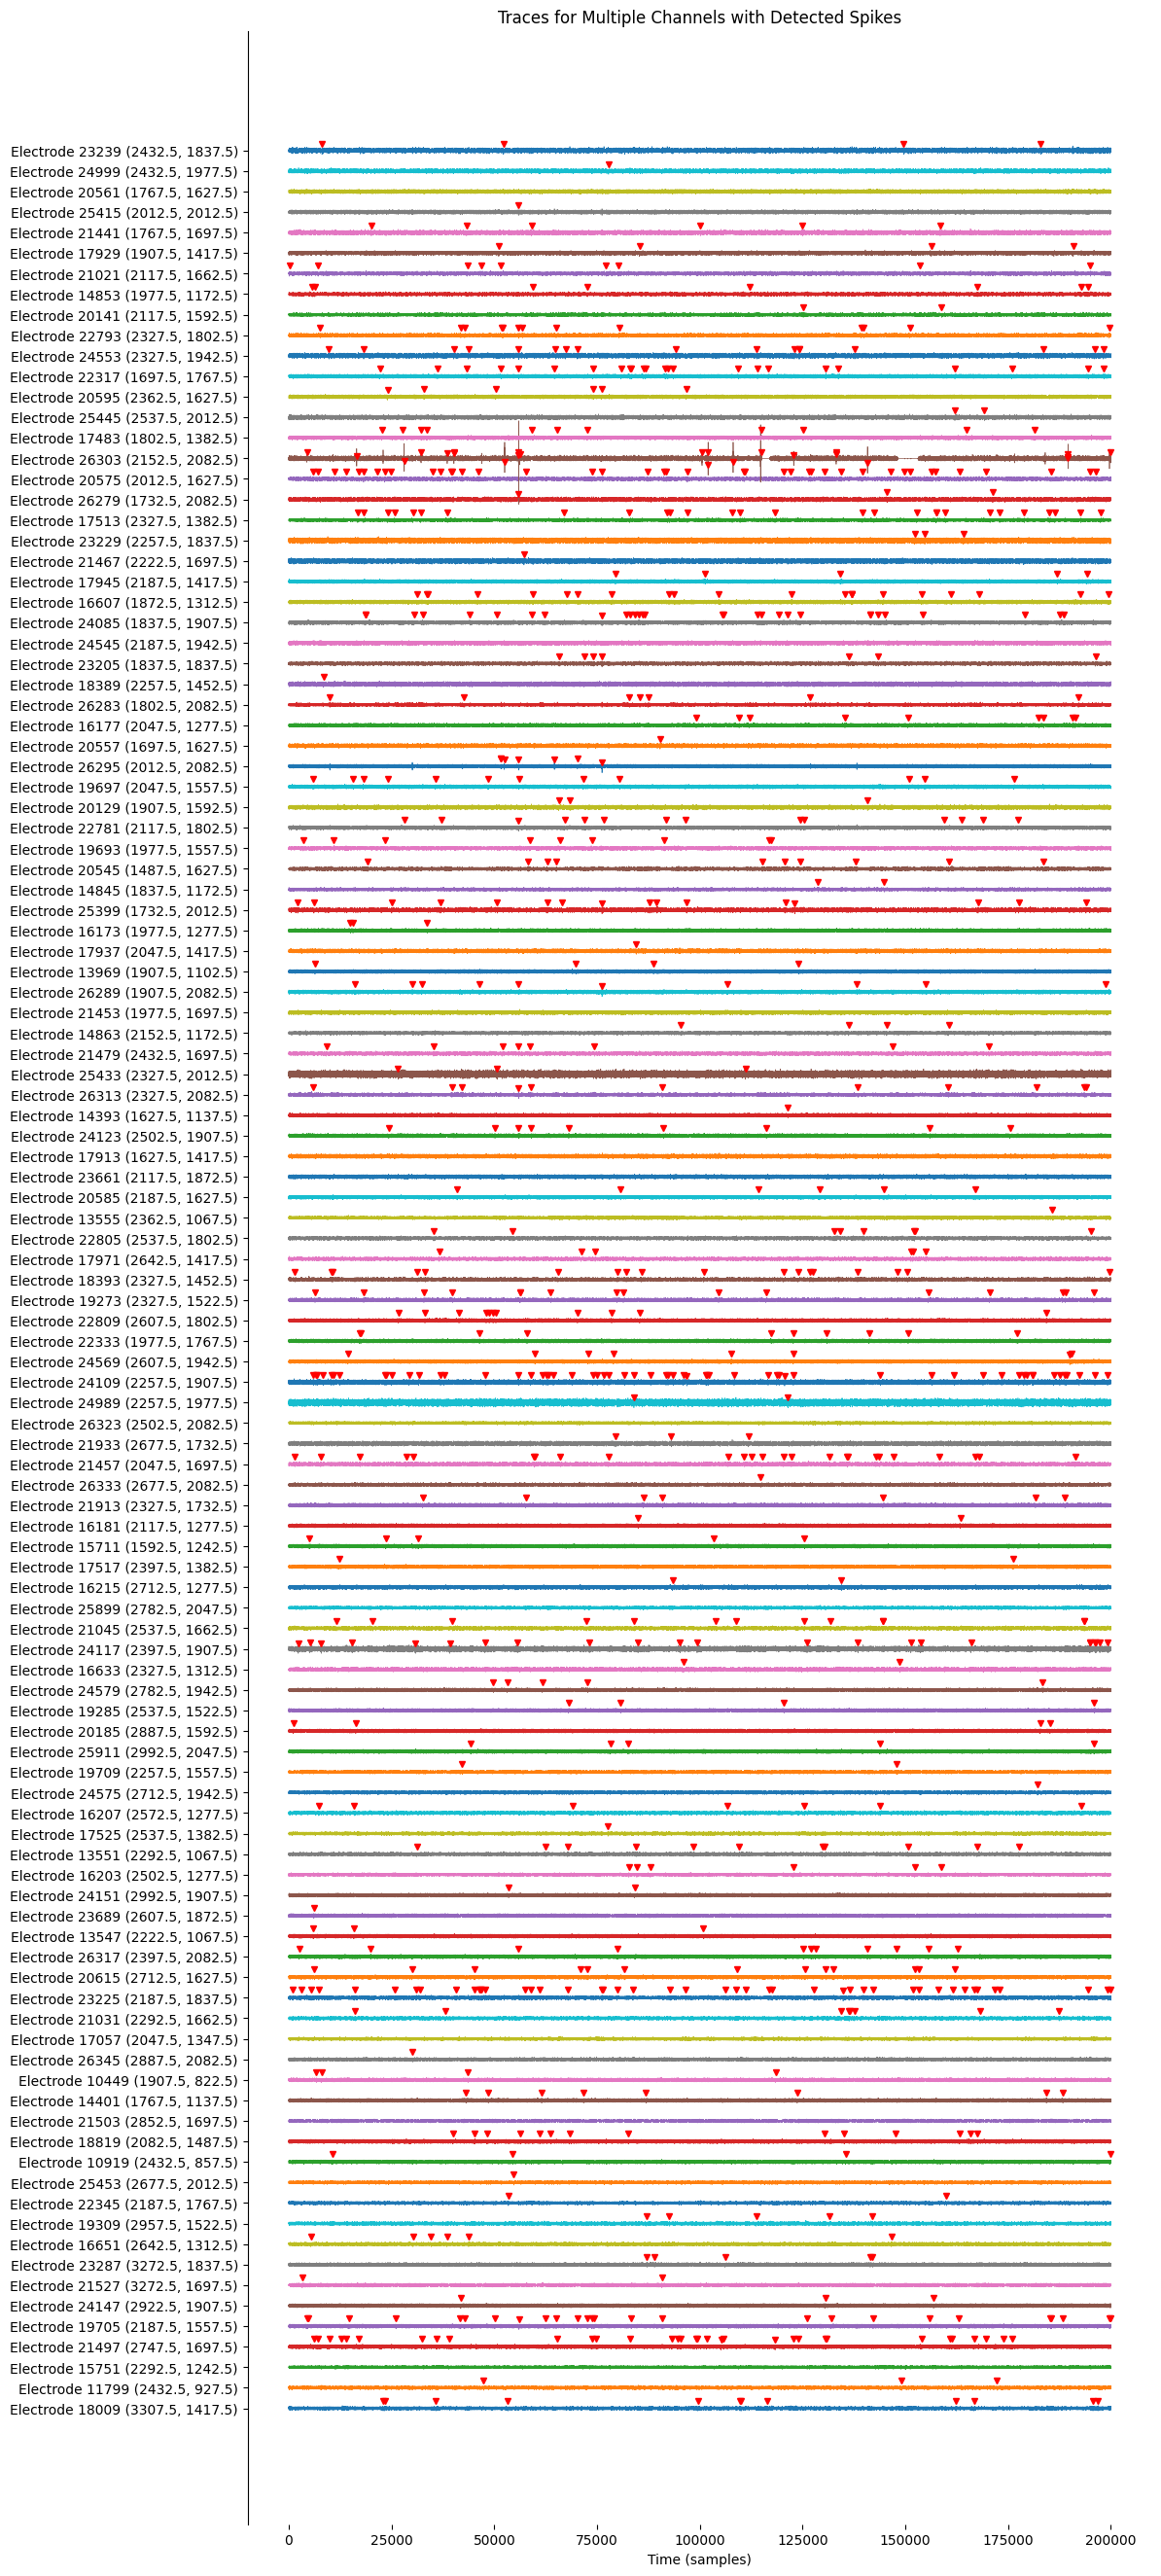

In [63]:
import os

import numpy as np
import matplotlib.pyplot as plt

plt.close('all')  # Close all existing figures to prevent multiple plots

# Define the detect_peaks_stddev function
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    """
    Detect peaks in a signal based on standard deviation thresholding.

    Parameters:
    - trace: 1D numpy array, the signal to analyze
    - peak_sign: str, "pos" for positive peaks, "neg" for negative peaks
    - std_multiplier: float, the threshold multiplier for peak detection

    Returns:
    - peaks: numpy array, indices of detected peaks
    - threshold: float, the threshold value used for detection
    """
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std

    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & (trace[1:-1] > trace[2:]) & (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & (trace[1:-1] < trace[2:]) & (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")

    return peaks, threshold
%matplotlib inline
# Ensure channels_to_plot only contains valid indices within the bounds of the traces array
channels_to_plot = [55, 563, 567, 571, 575, 595, 607, 611, 627, 631, 643, 647, 651, 655,
                                  659, 663, 667, 671, 675, 679, 683, 687, 691, 695, 699, 703, 707, 711,
                                  715, 723, 739, 747, 751, 755, 763, 767, 771, 775, 779, 783, 787, 791,
                                  799, 803, 807, 811, 815, 819, 823, 827, 831, 835, 839, 843, 847, 851,
                                  855, 859, 863, 867, 871, 875, 879, 883, 887, 891, 895, 898, 899, 902,
                                  903, 907, 910, 911, 914, 915, 918, 919, 923, 926, 927, 934, 935, 938,
                                  939, 942, 943, 947, 950, 951, 955, 959, 963, 966, 967, 971, 974, 975,
                                  979, 983, 987, 991, 995, 998, 999, 1003, 1007, 1011, 1015, 1019, 1023]
fs = recording_chunk.get_sampling_frequency()
start_time = 40 # Start time in seconds
end_time = 60 # End time in seconds
# Get traces for the specified range
traces = recording_chunk.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0, return_scaled=True)

# Define the channels you want to plot
 # Replace with the desired channel indices
#channels_to_plot = range(traces.shape[1])  # Example channel indices
# Parameters for spike detection
peak_sign = "neg"  # Detect negative peaks
std_multiplier = 4 # Threshold: 1 standard deviation from the mean

# Adjust figure height dynamically based on the number of channels
plt.figure(figsize=(12, len(channels_to_plot) * 0.3))  # Increase height for better spacing

# Extract channel IDs and 2D location coordinates
channel_ids = np.array([int(x) for x in recording_chunk.get_channel_ids()])
locs = recording_chunk.get_channel_locations()  # Define locs here
# Ensure channels_to_plot only contains valid indices within the bounds of the traces array
channels_to_plot_indices = [np.where(channel_ids == ch)[0][0] for ch in channels_to_plot if ch in channel_ids]

# Loop through the channels and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store channel names for labeling

spike_times_channel = {} # Store spike times for each channel
for i, channel_idx in enumerate(channels_to_plot_indices):
    # Get the trace for the current channel
    trace = traces[:, channel_idx]
    
    # Detect peaks using the detect_peaks function
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)

    
    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks_sample_inds.astype(int)
    spike_times_channel[channel] = peaks_sample_inds  # Store spike times for the channel

    spike_marker_offset = 100
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        label=f'Electrode {electrodes[channel_idx]}',  # Use the actual channel ID for labeling
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Channel {electrodes[channel_idx]}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * 200)
    
    # Retrieve the x, y coordinates for the channel
    x, y = locs[channel_idx]  # Use the index to get the location
    yticks_labels.append(f'Electrode {electrodes[channel_idx]} ({x:.1f}, {y:.1f})')  # Format with coordinates

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels with Detected Spikes')

# Add y-axis ticks with channel names and coordinates
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_multiple_channels_with_spikes.pdf'  # Replace with your desired path
plt.show() 
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
plt.close()  # Close the plot to free memory

In [64]:
#** TESTING THE ELECTRODES MAPPING **#
# Initialize the electrodes list
electrodes = []
channel_location_dict = {}

# Get channel IDs and locations
channel_ids = recording_chunk.get_channel_ids()
locations = recording_chunk.get_channel_locations()

# Populate the electrodes list
for channel, loc in zip(channel_ids, locations):
    # Calculate electrode ID based on location
    electrode_id = 220 * int(loc[1] / 17.5) + int(loc[0] / 17.5)
    electrodes.append(electrode_id)
    channel_location_dict[channel] = electrode_id  # Map channel to electrode

# Validate the electrodes list
if len(electrodes) != len(channel_ids):
    print(f"Warning: Mismatch between number of channels ({len(channel_ids)}) and electrodes ({len(electrodes)}).")
else:
    print(f"Successfully mapped {len(electrodes)} electrodes.")

Successfully mapped 1020 electrodes.


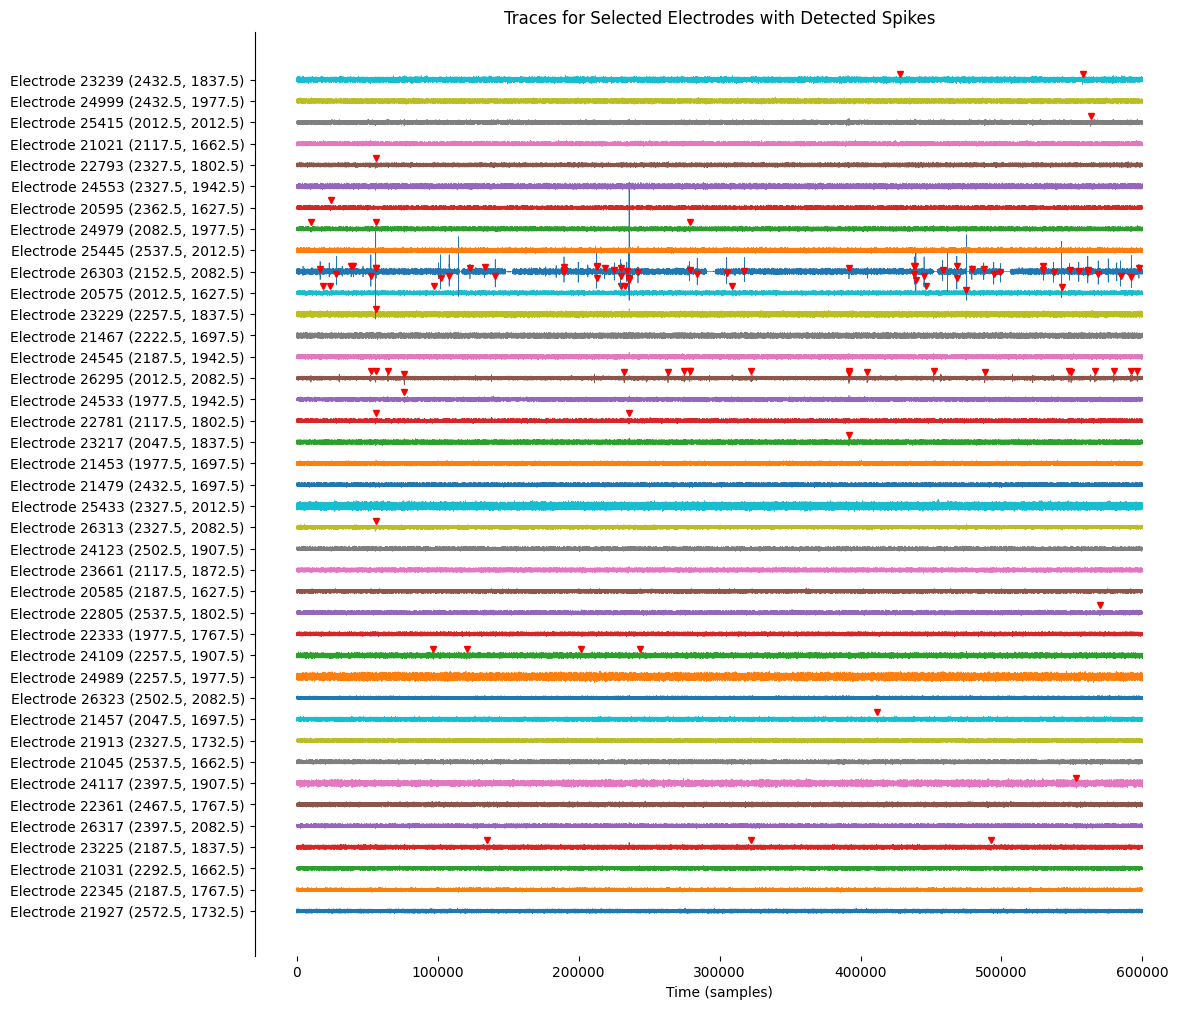

In [74]:
import os

import numpy as np
import matplotlib.pyplot as plt


# Define the detect_peaks_stddev function
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    """
    Detect peaks in a signal based on standard deviation thresholding.

    Parameters:
    - trace: 1D numpy array, the signal to analyze
    - peak_sign: str, "pos" for positive peaks, "neg" for negative peaks
    - std_multiplier: float, the threshold multiplier for peak detection

    Returns:
    - peaks: numpy array, indices of detected peaks
    - threshold: float, the threshold value used for detection
    """
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std

    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & (trace[1:-1] > trace[2:]) & (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & (trace[1:-1] < trace[2:]) & (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")

    return peaks, threshold

%matplotlib inline
plt.close('all')  # Close all existing figures to prevent multiple plots

# Replace this list with the provided electrode numbers
electrodes_to_plot = [
    21927, 22345, 21031, 23225, 26317, 22361, 24117, 21045, 21913, 21457, 
    26323, 24989, 24109, 22333, 22805, 20585, 23661, 24123, 26313, 25433, 
    21479, 21453, 23217, 22781, 24533, 26295, 24545, 21467, 23229, 20575, 
    26303, 25445, 24979, 20595, 24553, 22793, 21021, 25415, 24999, 23239
]

# Sampling frequency
fs = recording_chunk.get_sampling_frequency()

# Define the time range for extracting traces
start_time = 40  # Start time in seconds
end_time = 100    # End time in seconds

# Extract traces from the recording chunk
traces = recording_chunk.get_traces(
    start_frame=int(start_time * fs), 
    end_frame=int(end_time * fs), 
    segment_index=0, 
    return_scaled=True
)

peaks_sign = "neg"  # Peak sign for detection

std_multiplier = 5 # Standard deviation multiplier for peak detection
traces = recording_chunk.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0, return_scaled=True)


# Map electrodes to their corresponding channel indices
electrodes_to_plot_indices = [np.where(np.array(electrodes) == el)[0][0] for el in electrodes_to_plot if el in electrodes]

# Adjust figure height dynamically based on the number of electrodes
plt.figure(figsize=(12, len(electrodes_to_plot_indices) * 0.3))  # Increase height for better spacing

# Loop through the electrodes and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store electrode names for labeling

spike_times_electrode = {}  # Store spike times for each electrode
for i, electrode_idx in enumerate(electrodes_to_plot_indices):
    # Get the trace for the current electrode
    trace = traces[:, electrode_idx]
    
    # Detect peaks using the detect_peaks function
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier= std_multiplier)

    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks_sample_inds.astype(int)
    spike_times_electrode[electrodes[electrode_idx]] = peaks_sample_inds  # Store spike times for the electrode

    spike_marker_offset = 100
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        label=f'Electrode {electrodes[electrode_idx]}',  # Use the actual electrode ID for labeling
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Electrode {electrodes[electrode_idx]}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * 200)
    
    # Retrieve the x, y coordinates for the electrode
    x, y = locations[electrode_idx]  # Use the index to get the location
    yticks_labels.append(f'Electrode {electrodes[electrode_idx]} ({x:.1f}, {y:.1f})')  # Format with coordinates

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Selected Electrodes with Detected Spikes')

# Add y-axis ticks with electrode names and coordinates
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_selected_electrodes_with_spikes.pdf'  # Replace with your desired path
plt.show()
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
plt.close()  # Close the plot to free memory

Electrode 1101: 89.23 μm
Electrode 225: 89.23 μm
Electrode 1105: 123.74 μm
Electrode 1985: 180.17 μm
Electrode 2421: 193.29 μm
Electrode 671: 199.53 μm
Electrode 2865: 243.75 μm
Electrode 675: 267.70 μm
Electrode 1993: 276.70 μm
Electrode 3741: 298.01 μm
Electrode 3745: 310.10 μm
Electrode 3311: 325.52 μm
Electrode 241: 367.92 μm
Electrode 1121: 377.77 μm
Electrode 4191: 384.20 μm
Electrode 4627: 387.38 μm
Electrode 5063: 405.91 μm
Electrode 2881: 432.22 μm
Electrode 5507: 454.33 μm
Electrode 4199: 470.23 μm
Electrode 5941: 472.82 μm
Electrode 5511: 477.98 μm
Electrode 2007: 498.06 μm
Electrode 689: 510.21 μm
Electrode 6387: 522.08 μm
Electrode 2887: 524.42 μm
Electrode 5517: 529.07 μm
Electrode 6391: 542.78 μm
Electrode 3767: 558.36 μm
Electrode 6397: 588.27 μm
Electrode 5523: 594.49 μm
Electrode 7703: 614.75 μm
Electrode 3771: 618.72 μm
Electrode 2893: 620.70 μm
Electrode 7707: 624.63 μm
Electrode 4649: 626.59 μm
Electrode 7711: 642.04 μm
Electrode 6403: 647.74 μm
Electrode 1137: 653

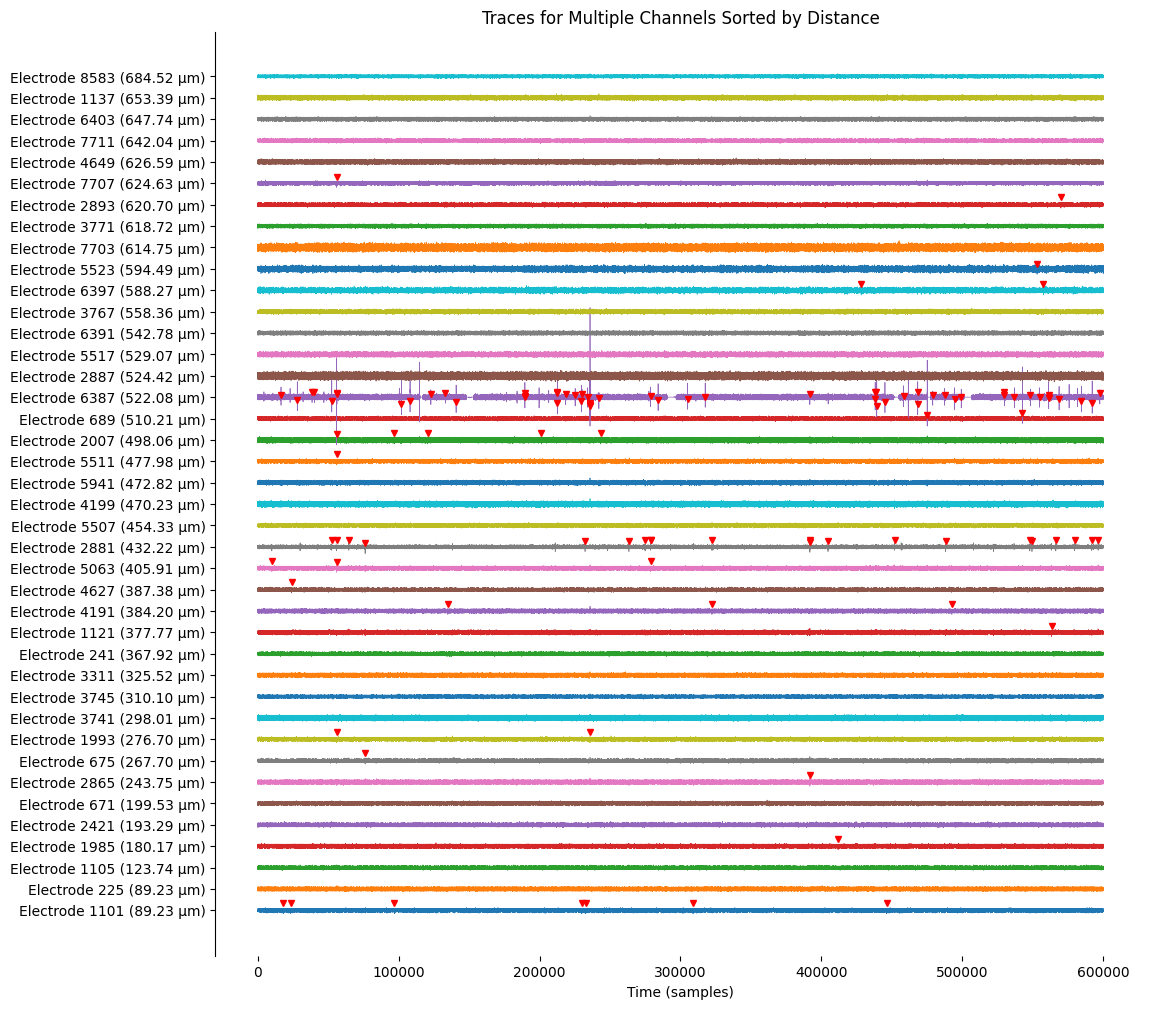

In [75]:
# Sort electrodes based on distance from reference point (0, 0)

import numpy as np
import matplotlib.pyplot as plt

# Define the reference point
reference_point = (0, 0)

# Retrieve the 2D locations of the electrodes
locs = recording_chunk.get_channel_locations()

# Calculate distances for each electrode
distances = np.sqrt((locs[:, 0] - reference_point[0])**2 + (locs[:, 1] - reference_point[1])**2)

# Sort electrodes by distance (ascending order)
sorted_indices = np.argsort(distances)
sorted_electrodes = [electrodes[idx] for idx in sorted_indices]
sorted_distances = distances[sorted_indices]


for electrode, distance in zip(sorted_electrodes, sorted_distances):
    print(f"Electrode {electrode}: {distance:.2f} μm")

# Update the order of electrodes to plot based on sorted electrodes
electrodes_to_plot_sorted = [electrode for electrode in sorted_electrodes if electrode in electrodes_to_plot]


# Validate that electrodes_to_plot_sorted is not empty
if not electrodes_to_plot_sorted:
    raise ValueError("The `electrodes_to_plot_sorted` list is empty. Ensure `electrodes_to_plot` and `electrodes` are correctly defined.")

# Plot the sorted electrodes
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store electrode names for labeling

plt.figure(figsize=(12, len(electrodes_to_plot_sorted) * 0.3))  # Adjust figure height dynamically

spike_marker_offset = 100  # Define spike marker offset

for i, electrode in enumerate(electrodes_to_plot_sorted):
    electrode_idx_array = np.where(np.array(electrodes) == electrode)[0]
    if electrode_idx_array.size == 0:
        print(f"Warning: Electrode {electrode} not found in electrodes.")
        continue  # Skip this electrode if it is not found
    trace = traces[:, electrode_idx_array[0]]
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)

    # Check if spikes are detected
    if len(peaks_sample_inds) == 0:
        print(f"Warning: No spikes detected for electrode {electrode}.")

    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )

    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Electrode {electrodes[electrode_idx]}'
    )
    yticks_positions.append(i * 200)
    yticks_labels.append(f'Electrode {sorted_electrodes[i]} ({sorted_distances[i]:.2f} μm)')

     

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels Sorted by Distance')
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './sorted_traces_by_distance.pdf'
plt.show()
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)
plt.close()



In [67]:
print(electrodes_to_plot)

[22783, 25426, 24341, 23885, 25204, 23229, 24121, 24561, 25439, 23449, 25658, 24339, 24340, 24554, 25211, 24320, 23002, 24319, 24761, 22782, 25861, 24104, 25438, 23224, 24774, 25879, 24985, 23228, 26088, 24770, 25437, 25659, 24120, 24105, 24336, 23448, 24559, 25868, 25877, 25657, 24555, 24335, 23886, 22784, 24984, 26310, 23222, 25641, 25869, 23009, 23008, 24560, 23447, 23227, 26075, 24990, 25878, 26308, 24556, 26083, 25860, 24775, 24989, 25419, 26304, 25424, 24119, 26297, 24334, 23884, 24760, 25859, 24540, 26076, 26090, 24776, 25210, 25421, 23223, 24324, 26295, 25206, 25425, 24539, 26296, 26077, 24326, 24759, 26084, 25639, 26305, 24321, 25420, 24541, 26309, 26303, 25640, 24991, 23003, 26085, 24325, 25205, 23007, 23004, 24106, 24986, 25209, 26089, 24769, 24771, 25870]


In [68]:
# Extract channel IDs and 2D location coordinates
channel_ids =np.array([int(x) for x in recording_chunk.get_channel_ids()])
locs = recording_chunk.get_channel_locations()
channel_to_highlight = electrodes_to_plot # Channels to highlight



In [69]:
print(channel_to_highlight)

[22783, 25426, 24341, 23885, 25204, 23229, 24121, 24561, 25439, 23449, 25658, 24339, 24340, 24554, 25211, 24320, 23002, 24319, 24761, 22782, 25861, 24104, 25438, 23224, 24774, 25879, 24985, 23228, 26088, 24770, 25437, 25659, 24120, 24105, 24336, 23448, 24559, 25868, 25877, 25657, 24555, 24335, 23886, 22784, 24984, 26310, 23222, 25641, 25869, 23009, 23008, 24560, 23447, 23227, 26075, 24990, 25878, 26308, 24556, 26083, 25860, 24775, 24989, 25419, 26304, 25424, 24119, 26297, 24334, 23884, 24760, 25859, 24540, 26076, 26090, 24776, 25210, 25421, 23223, 24324, 26295, 25206, 25425, 24539, 26296, 26077, 24326, 24759, 26084, 25639, 26305, 24321, 25420, 24541, 26309, 26303, 25640, 24991, 23003, 26085, 24325, 25205, 23007, 23004, 24106, 24986, 25209, 26089, 24769, 24771, 25870]


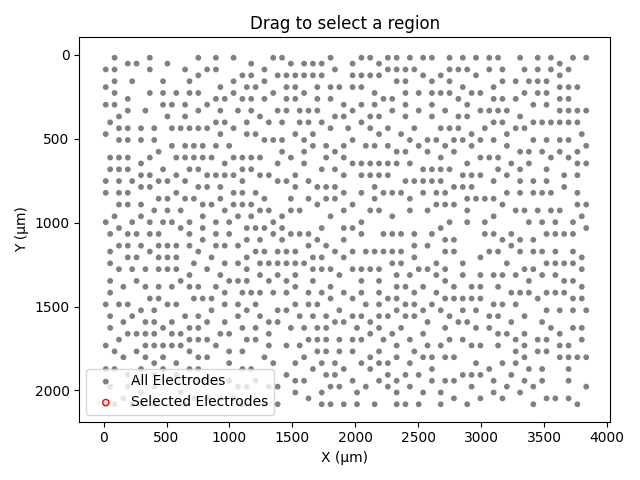

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

# Enable interactive matplotlib
%matplotlib widget

# Ensure required variables are defined
# Replace these with your actual data
locs = recording_chunk.get_channel_locations()  # 2D locations of electrodes
channel_ids = recording_chunk.get_channel_ids()  # Channel IDs
electrodes = np.array(electrodes)  # List of electrode IDs
# Widgets to enter electrode IDs to highlight
highlight_input = widgets.Text(
    description='Highlight:',
    placeholder='e.g. 10, 15, 23',
    layout=widgets.Layout(width='50%')
)

highlight_button = widgets.Button(
    description='Highlight Electrodes',
    button_style='info'
)

# Setup figure
fig, ax = plt.subplots()

# Initial colors: all gray
c = np.array(['gray'] * len(electrodes))

def update_highlight_colors(electrodes_to_highlight):
    global c
    c = np.array(['gray'] * len(electrodes))
    highlight_mask = np.isin(electrodes, electrodes_to_highlight)
    c[highlight_mask] = 'blue'
    sc.set_color(c)
    fig.canvas.draw_idle()


# Scatter plot of electrode locations
sc = ax.scatter(locs[:, 0], locs[:, 1], c=c, label='All Electrodes', s=10)
ax.set_title("Drag to select a region")
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)")

# Invert the y-axis to match typical electrode layouts
ax.invert_yaxis()

# Scatter plot for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Electrodes')
selected_electrodes = []

# Create an output widget for displaying messages
output = widgets.Output()

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_electrodes
    if eclick.xdata is None or erelease.xdata is None:  # Ignore clicks outside the plot
        return

    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata

    # Mask to find electrodes within the selected region
    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = electrodes[mask]

    # Check if Ctrl key is pressed (use event modifiers)
    if eclick.key == 'control':  # Append to existing selection
        selected_electrodes = np.unique(np.concatenate((selected_electrodes, new_selection)))
    else:  # Overwrite selection
        selected_electrodes = new_selection

    # Update the scatter plot for selected electrodes
    selected_plot.set_offsets(locs[np.isin(electrodes, selected_electrodes)])
    fig.canvas.draw_idle()

    # Display the selection details in the output widget
    with output:
        output.clear_output()  # Clear previous messages
        print(f"🔴 Selected {len(selected_electrodes)} electrodes")
        print(selected_electrodes)

# Create RectangleSelector
selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]  # Left mouse button
)

# Create save button
save_button = widgets.Button(
    description="💾 Save Selected Electrodes",
    button_style='success',
    tooltip='Save selected electrode IDs to file'
)


def on_highlight_button_click(b):
    with output:
        output.clear_output()
        try:
            input_text = highlight_input.value.strip()
            if input_text == "":
                print("No electrodes entered.")
                return
            electrodes_to_highlight = np.array([int(x.strip()) for x in input_text.split(',')])
            update_highlight_colors(electrodes_to_highlight)
            print(f"🔵 Highlighted electrodes: {electrodes_to_highlight}")
        except Exception as e:
            print(f"Error parsing input: {e}")

highlight_button.on_click(on_highlight_button_click)

# Define callback to save to file
def save_selected_electrodes_to_file(b):
    if len(selected_electrodes) == 0:
        with output:
            output.clear_output()
            print("No electrodes selected to save.")
        return

    save_path = "selected_electrodes.txt"
    with open(save_path, "w") as f:
        for el in selected_electrodes:
            f.write(f"{el}\n")

    with output:
        output.clear_output()
        print(f"Saved {len(selected_electrodes)} electrode IDs to {os.path.abspath(save_path)}")

# Attach callback and show button
save_button.on_click(save_selected_electrodes_to_file)
# Display all controls
display(widgets.VBox([
    widgets.HBox([highlight_input, highlight_button]),
    save_button,
    output
]))

plt.legend()
plt.tight_layout()
plt.show()

In [71]:
print("Number of selected electrodes:", len(electrodes_to_plot))

print(electrodes[:5])
print(type(electrodes[0]))
electrodes = electrodes.astype(int)

Number of selected electrodes: 111
[12145 13199 13431 15397 14317]
<class 'numpy.int64'>


In [77]:
# Print the number of selected electrodes
print(f"Number of selected electrodes: {(electrodes_to_plot)}")

# Function to calculate the firing rate for a given electrode
def calculate_metrics(spike_times, total_duration):
    total_spikes = len(spike_times)
    # Calculate firing rate
    firing_rate = total_spikes / total_duration if total_duration > 0 else 0

    # Calculate interspike intervals (ISI)
    interspike_intervals = np.diff(spike_times)
    mean_isi = np.mean(interspike_intervals)
    std_isi = np.std(interspike_intervals)

    # Detect bursts (example: spikes within 0.1 seconds are considered part of a burst)
    burst_threshold = 0.1  # Time in seconds
    burst_indices = np.where(interspike_intervals < burst_threshold)[0]
    num_bursts = len(burst_indices)
    spikes_per_burst = num_bursts + 1  # Each burst has at least 2 spikes
    burst_peak = np.max(interspike_intervals) if num_bursts > 0 else 0
    
    return firing_rate if total_duration > 0 else 0

# Example: Total duration of the recording in seconds
total_duration = recording_chunk.get_total_duration()

# Create a list to store the data for the table
data = []

# Iterate over the selected electrodes
for electrode in electrodes_to_plot:
    if electrode in spike_times_electrode:
        spike_times = spike_times_electrode[electrode]
        firing_rate = calculate_metrics(spike_times, total_duration)
        data.append({"Electrode": electrode, "Total Spikes": len(spike_times), "Firing Rate (Hz)": firing_rate})
    else:
        data.append({"Electrode": electrode, "Firing Rate (Hz)": "No spikes detected"})

# Create a DataFrame from the data
firing_rate_table = pd.DataFrame(data)

# Display the table
print(firing_rate_table)

firing_rate_table = pd.DataFrame(data)
firing_rate_table

# Optionally, save the table to a CSV file
firing_rate_table.to_csv("electrodes_frtable_run2well3nospicy.csv", index=False)

Number of selected electrodes: [21927, 22345, 21031, 23225, 26317, 22361, 24117, 21045, 21913, 21457, 26323, 24989, 24109, 22333, 22805, 20585, 23661, 24123, 26313, 25433, 21479, 21453, 23217, 22781, 24533, 26295, 24545, 21467, 23229, 20575, 26303, 25445, 24979, 20595, 24553, 22793, 21021, 25415, 24999, 23239]
    Electrode  Total Spikes  Firing Rate (Hz)
0       21927             0          0.000000
1       22345             0          0.000000
2       21031             0          0.000000
3       23225             3          0.010000
4       26317             0          0.000000
5       22361             0          0.000000
6       24117             1          0.003333
7       21045             0          0.000000
8       21913             0          0.000000
9       21457             1          0.003333
10      26323             0          0.000000
11      24989             0          0.000000
12      24109             4          0.013333
13      22333             0          0.00000

/home/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
